# Quick start skforecast

Welcome to a quick start guide to using **skforecast**! In this guide, we will provide you with a code example that demonstrates how to create, validate, and optimize a recursive multi-step forecaster, `ForecasterAutoreg`, using skforecast.

A **Forecaster** object in the skforecast library is a comprehensive container that provides essential functionality and methods for training a forecasting model and generating predictions for future points in time.

If you need more detailed documentation or guidance, you can visit the [User Guides](https://skforecast.org/latest/user_guides/user-guides.html) section.

Without further ado, let's jump into the code example!

## Libraries

In [16]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

from skforecast.datasets import load_demo_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

## Data

In [17]:
# Download data
# ==============================================================================
data = load_demo_dataset()
data.head(5)

datetime
1991-07-01    0.429795
1991-08-01    0.400906
1991-09-01    0.432159
1991-10-01    0.492543
1991-11-01    0.502369
Freq: MS, Name: y, dtype: float64

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


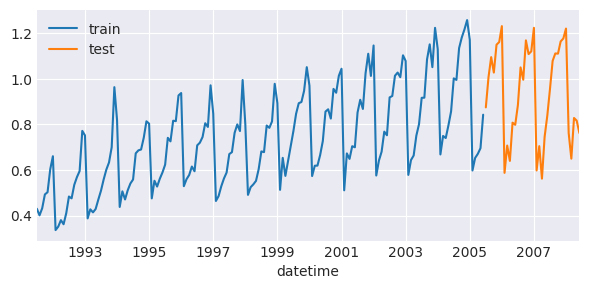

In [18]:
# Data partition train-test
# ==============================================================================
end_train = '2005-06-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend()
plt.show();

## Train a forecaster

Let's start by training a forecaster! For a more in-depth guide to using `ForecasterAutoreg`, visit the [User guide ForecasterAutoreg](https://skforecast.org/latest/user_guides/autoregresive-forecaster.html).

In [19]:
# Create and fit a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 15
             )

forecaster.fit(y=data.loc[:end_train])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-07-17 07:34:29 
Last fit date: 2024-07

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To understand what can be done when initializing a forecaster with <b>skforecast</b> visit <a href="https://skforecast.org/latest/quick-start/forecaster-parameters">Forecaster parameters</a> and <a href="https://skforecast.org/latest/quick-start/forecaster-attributes">Forecaster attributes</a>. 

</div>

## Prediction

After training the forecaster, the `predict` method can be used to make predictions for the future $n$ steps.

In [20]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
predictions.head(3)

2005-07-01    1.020833
2005-08-01    1.021721
2005-09-01    1.093488
Freq: MS, Name: pred, dtype: float64

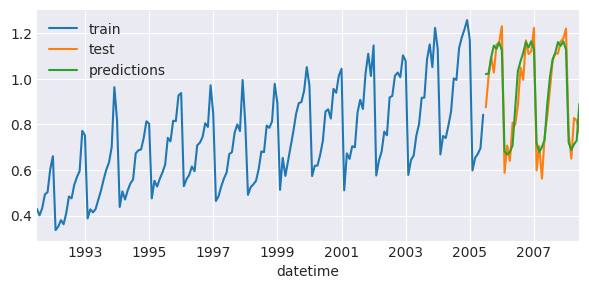

In [21]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [22]:
# Prediction error on test data
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data.loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.006023571131075229


## Backtesting: forecaster validation

In time series forecasting, backtesting refers to the process of validating a predictive model using historical data. The technique involves moving backwards in time, step-by-step, to assess how well a model would have performed if it had been used to make predictions during that time period. Backtesting is a form of cross-validation that is applied to previous periods in the time series.

Backtesting can be done using a variety of techniques, such as simple train-test splits or more sophisticated methods like rolling windows or expanding windows. The choice of method depends on the specific needs of the analysis and the characteristics of the time series data. For more detailed documentation on backtesting, visit: [User guide Backtesting forecaster](https://skforecast.org/latest/user_guides/backtesting.html).

In [23]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 10,
                                   metric                = 'mean_squared_error',
                                   initial_train_size    = len(data.loc[:end_train]),
                                   fixed_train_size      = False,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = True,
                                   n_jobs                = 'auto',
                                   verbose               = True,
                                   show_progress         = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 4
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 6 observations.

Fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-04-01 00:00:00  (n=10)
Fold: 1
    Training:   1991-07-01 00:00:00 -- 2006-04-01 00:00:00  (n=178)
    Validation: 2006-05-01 00:00:00 -- 2007-02-01 00:00:00  (n=10)
Fold: 2
    Training:   1991-07-01 00:00:00 -- 2007-02-01 00:00:00  (n=188)
    Validation: 2007-03-01 00:00:00 -- 2007-12-01 00:00:00  (n=10)
Fold: 3
    Training:   1991-07-01 00:00:00 -- 2007-12-01 00:00:00  (n=198)
    Validation: 2008-01-01 00:00:00 -- 2008-06-01 00:00:00  (n=6)



  0%|          | 0/4 [00:00<?, ?it/s]

Backtest error: 0.0064732563973605925


## Hyperparameter tuning and lags selection

Hyperparameter tuning is a crucial aspect of developing accurate and effective machine learning models. In machine learning, hyperparameters are values that cannot be learned from data and must be set by the user before the model is trained. These hyperparameters can significantly impact the performance of the model, and tuning them carefully can improve its accuracy and generalization to new data. In the case of forecasting models, the lags included in the model can be considered as an additional hyperparameter.

Hyperparameter tuning involves systematically testing different values or combinations of hyperparameters (including lags) to find the optimal configuration that produces the best results. The Skforecast library offers various hyperparameter tuning strategies, including grid search, random search, and Bayesian search. For more detailed documentation on Hyperparameter tuning, visit: [Hyperparameter tuning and lags selection](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

In [24]:
# Grid search hyperparameter and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 10,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.016405876616325348



In [25]:
# Grid results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.016406,5,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.017525,10,50
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.017525,15,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.019588,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.019902,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.019902,15,100
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.040534,10,100
5,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.040534,15,100
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044829,10,50
4,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.044829,15,50


Since `return_best = True`, the forecaster object is updated with the best configuration found and trained with the whole data set. This means that the final model obtained from grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

In [26]:
# Print forecaster information
# ==============================================================================
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=5, n_estimators=50, random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-07-17 07:34:29 
Last fit 